### Train & Save TorchPipeline

Train the `TorchPipleline` **training set**, evaluate on **dev** and **test**, and save the fitted pipeline.

In [1]:
import os

import random
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
from torchvision import transforms

from utils import get_image_paths_and_labels, plot_cm_subset
from TorchPipeline import TorchPipeline

TRAIN_DIR = '../data/asl_alphabet_train'
DEV_DIR = '../data/asl_alphabet_dev'
TEST_DIR = '../data/synthetic_test'

seed = 42
random.seed(seed)
np.random.seed(seed)

train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
dev_paths, dev_labels = get_image_paths_and_labels(DEV_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

classes = sorted(os.listdir(TRAIN_DIR))
subset_to_plot = [clazz for clazz in classes if clazz not in ['del', 'space']]

#### Training

Selecting backend

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

pipe = TorchPipeline(device=device)

Using device: mps


Visualize Training‐Time Augmentations

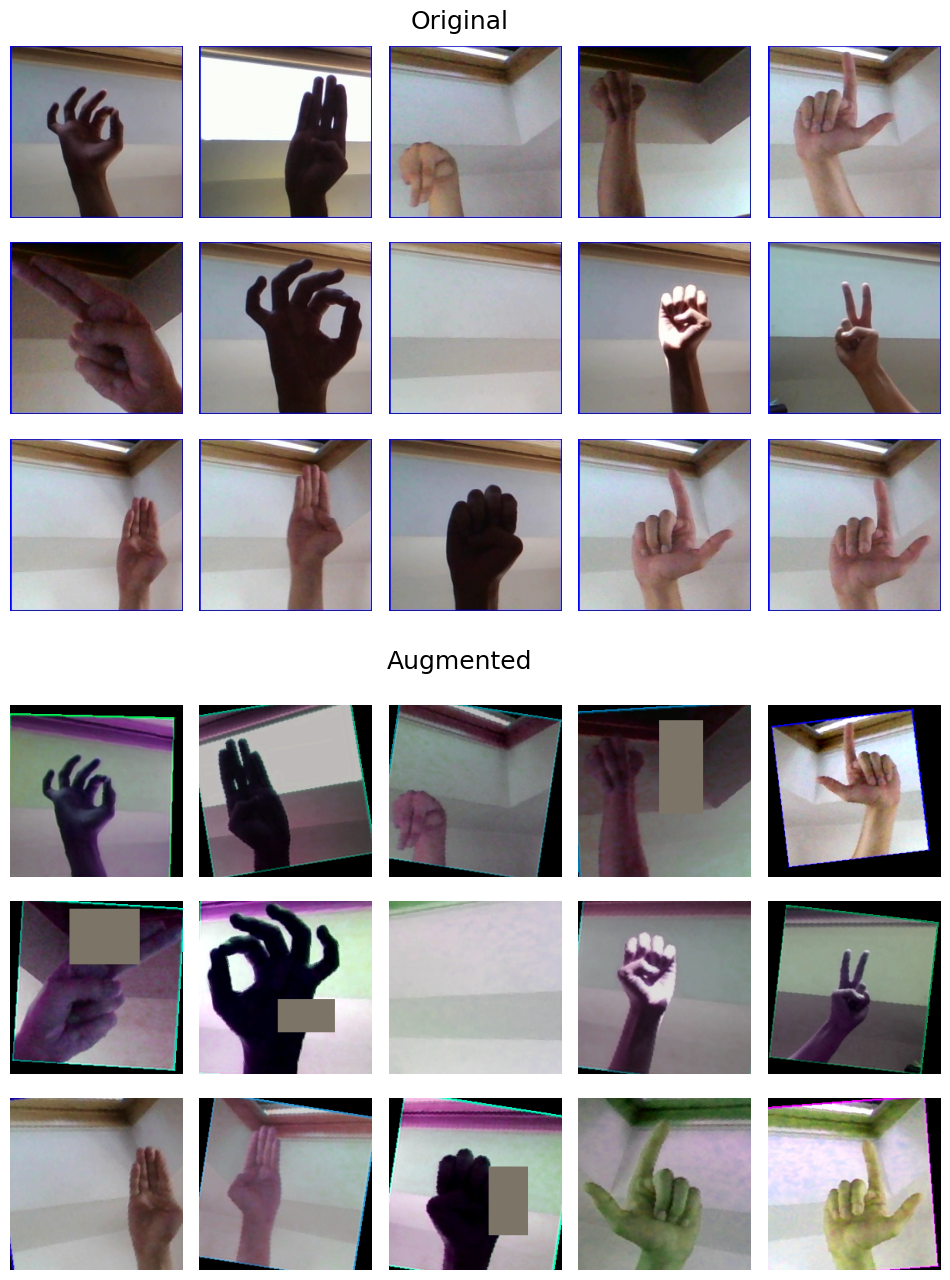

In [3]:
random.seed(42)
np.random.seed(42)

sample_paths = random.sample(train_paths, 15)

originals = [Image.open(p).convert("RGB") for p in sample_paths]
aug_tensors = [
    pipe.transform_train(Image.open(p).convert("RGB")).cpu()
    for p in sample_paths
]

inv_norm = transforms.Normalize(
    mean=[-m / s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1 / s for s in [0.229, 0.224, 0.225]]
)

aug_images = []
for t in aug_tensors:
    img = inv_norm(t)
    img = img.permute(1, 2, 0).numpy()
    aug_images.append(np.clip(img, 0, 1))

fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(
    nrows=7, ncols=5,
    height_ratios=[1, 1, 1, 0.3, 1, 1, 1],  # small “gap” row at index=3
    hspace=0.1, wspace=0.1
)

for idx in range(15):
    r, c = divmod(idx, 5)
    ax1 = fig.add_subplot(gs[r, c])
    ax1.imshow(originals[idx])
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[r + 4, c])
    ax2.imshow(aug_images[idx])
    ax2.axis("off")

# 6) block titles centered above each 3-row group
fig.text(0.5, 0.90, "Original", ha="center", va="top", fontsize=18)
fig.text(0.5, 0.50, "Augmented", ha="center", va="top", fontsize=18)

plt.show()

Finding optimal learning rate

LR finder: 100%|██████████| 2358/2358 [04:08<00:00,  9.50batch/s]


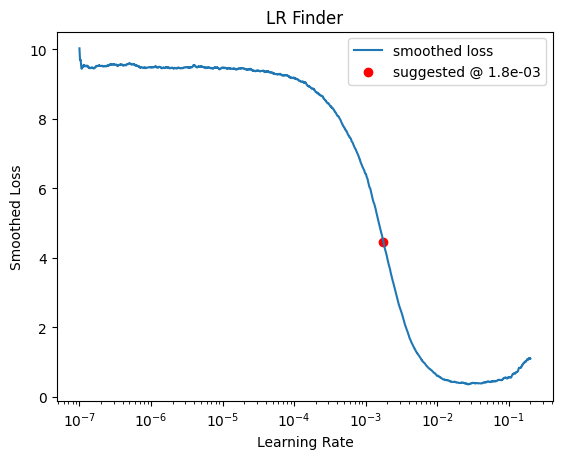

Suggested LR = 1.77e-03


In [4]:
lrs, losses, suggested_lr = pipe.find_learning_rate(train_paths, train_labels)

plt.plot(lrs, losses, label="smoothed loss")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Smoothed Loss")
plt.title("LR Finder")
plt.scatter([suggested_lr], [losses[lrs.index(suggested_lr)]], color='red', label=f"suggested @ {suggested_lr:.1e}")
plt.legend()
plt.show()

print(f"Suggested LR = {suggested_lr:.2e}")

Learning on train

In [5]:
pipe.fit(train_paths, train_labels, lr=suggested_lr)
print("Trained TorchPipeline on train")

Head params: 2 Backbone params: 60


Epoch 5: 100%|██████████| 2358/2358 [04:52<00:00,  8.06batch/s, acc=0.9657, f1=0.9657, loss=0.1194]

Trained TorchPipeline on train


#### Evaluate on dev

Predict: 100%|██████████| 363/363 [00:37<00:00,  9.74batch/s]


### DEV SET ###
Accuracy     : 0.9980
Macro-F1     : 0.9980


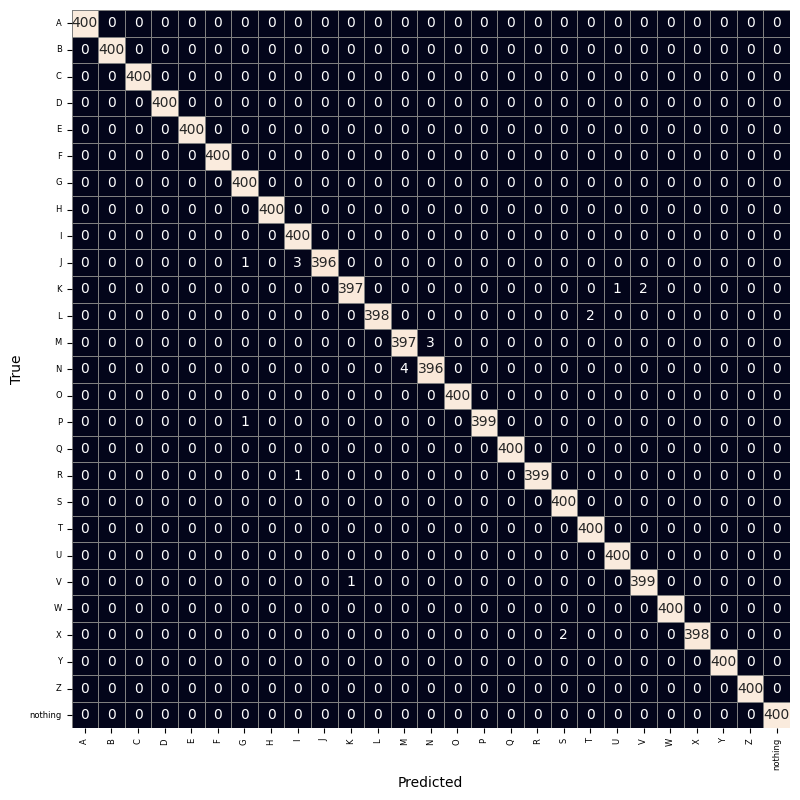

In [6]:
dev_metrics = pipe.evaluate(dev_paths, dev_labels)

print("### DEV SET ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

plot_cm_subset(dev_metrics['cm'], classes, subset_to_plot)

#### Evaluate on test

Predict: 100%|██████████| 85/85 [00:30<00:00,  2.81batch/s]


### TEST SET ###
Accuracy     : 0.2852
Macro-F1     : 0.2682


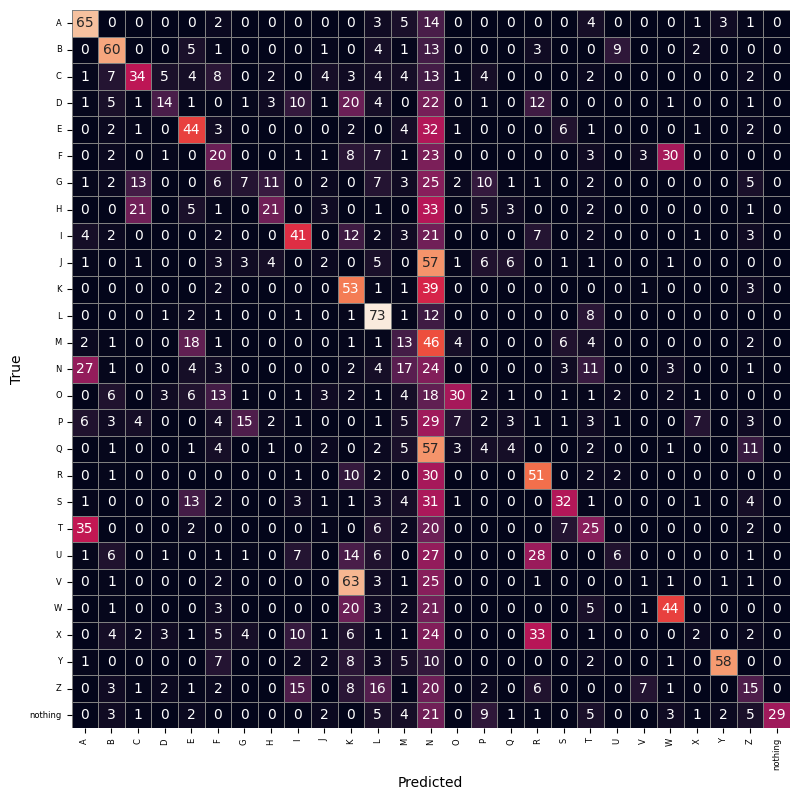

In [7]:
test_metrics = pipe.evaluate(test_paths, test_labels)

print("### TEST SET ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

plot_cm_subset(test_metrics['cm'], classes, subset_to_plot)

#### Save model

In [8]:
out = Path('../models') / 'torch_pipeline.pth'
out.parent.mkdir(exist_ok=True, parents=True)
pipe.save(str(out))
print(f"Saved TorchPipeline to {out}")

Saved TorchPipeline to ../models/torch_pipeline.pth


#### Load Model and evaluate again

In [9]:
pipe2 = TorchPipeline(device=device).load(str(out))
print(f"Loaded pipeline from {out}\n")

# 1) Eval on DEV
dev_metrics = pipe2.evaluate(dev_paths, dev_labels)
print("### DEV SET (reloaded) ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

# 2) Eval on TEST
test_metrics = pipe2.evaluate(test_paths, test_labels)
print("### TEST SET (reloaded) ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

Loaded pipeline from ../models/torch_pipeline.pth



Predict: 100%|██████████| 363/363 [00:36<00:00,  9.88batch/s]


### DEV SET (reloaded) ###
Accuracy     : 0.9980
Macro-F1     : 0.9980


Predict: 100%|██████████| 85/85 [00:30<00:00,  2.82batch/s]

### TEST SET (reloaded) ###
Accuracy     : 0.2852
Macro-F1     : 0.2682
